# Обучение классификатора на реальном датасете.

## Пояснение:
Требуется обучить классификатор определяющий тип велосипеда на небольшом датасете фотографий велосипедов из открытых источников. Допускается использовать пред-обученные модели из torchvision.models
По результатам работы составьте отчет.

## Задачи:

* Загрузите Датасет по ссылке: http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip Используйте встроенные классы из пакета torchvision.datasets либо создайте свой являющийся наследником базового класса Dataset из этого пакета.
* Проведите аугментацию данных как минимум 3-мя различными способами. Хотя бы одни из них должен быть реализован самостоятельно.
* Используйте технологию Transfer learning: 
** измените выходной слой выбранной вами предобученной модели.
** Заморозьте часть весов.
* Обучите модель с использование GPU. Учитывайте особенности данных при выборе и настройке Loss-функции
*Оцените результаты.
* Напишите отчет.



*Сохраняйте веса модели на GoogleDrive

In [1]:
import albumentations as A

import wandb
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy as accuracy_metric
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import InterpolationMode

In [ ]:
wandb.login()

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
# Custom data augmentation
class CustomNoise:
    def __init__(self, intense):
        assert 0 < intense <= 10
        self.intense = intense

    def __call__(self, sample):
        sigma = sample.mean() / 10 * self.intense
        noise = torch.normal(sample.mean(), sigma)

        return sample + noise

In [12]:
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # CustomNoise(3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
train_dataset = ImageFolder('bike_type/train', transform=transform_train)
val_dataset = ImageFolder('bike_type/val', transform=transform_val)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True,
                              num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            shuffle=False,
                            num_workers=4)

Smoke test

In [ ]:
for batch in train_dataloader:
    images, class_nums = batch
    break
plt.imshow(images[1].permute(1, 2, 0))
print('Size:', images[1].shape)
plt.show()

## Let`s use some Lightning!

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

seed_everything(123456)

# Gonna make trainer for small resnets
class ImportedModelTrainer(pl.LightningModule):
    def __init__(self, model, pretrained, lr=1e-3):
        super().__init__()
        self.model = model
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False

        # Freeze seed_everything without
        # 1) last conv block
        # 2) fc layer
        self.model.layer4[2].requires_grad_(True)
        self.model.fc = nn.Linear(512, 5)
        self.learning_rate = lr

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

        # Scheduler for lr
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=25, verbose=True, factor=0.7)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler, "monitor": "accuracy"}

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch

        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.scheduler.step(loss)
        acc = accuracy_metric(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [4]:
from torchvision.models import resnet34, ResNet34_Weights

# I don`t want to use big and hard architectures so I will try transfer learning for resnet34
rs = resnet34()
rs.layer4[2]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Training things

In [18]:
device = 'cuda:0'

model = resnet34(weights=ResNet34_Weights.DEFAULT).to(device)
module = ImportedModelTrainer(model=model, pretrained=True, lr=3e-5)

In [11]:
wandb.finish()
wandb.init(project="cv-realdata", entity="dmitysh")
wandb_logger = WandbLogger(log_model='all')
trainer = pl.Trainer(accelerator="gpu", devices=-1, max_epochs=50, logger=wandb_logger, log_every_n_steps=18)

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)

I use my own pc, not colab. That's why just using torch save to local directory

In [13]:
torch.save(model.state_dict(), 'saved_models/good-rn34')

In [7]:
saved_model = resnet34(num_classes=5)
saved_model.load_state_dict(torch.load('saved_models/good-rn34'))

<All keys matched successfully>

In [22]:
def validate(model, testloader, device="cpu"):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(testloader):
            labels = labels.to(device)
            outputs = model(images.to(device))

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    return correct / total

In [24]:
saved_model.eval()
saved_model.to(device)

accuracy = validate(saved_model, val_dataloader, device)
print(f"Accuracy on val: {accuracy}")

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

Accuracy on val: 0.6984815618221258


# Отчет

* Использовал ImageFolder
* Сделал кастомный dummy шум
* Использовал простые аугментации
* Как обычно, графики мониторил на Wandb
* Понижал learning rate с помощью шедулера
* На этот раз использовал Lightning
* Файнтюнил предобученный resnet34 путем обучения линейного слоя и последнего блока со свертками
* Научился сохранять веса модели
* Финальная accuracy - почти 0.7 (при константном прогнозе - 0.2),
причем модель обучается и предсказывает очень быстро так как архитектура не сверхсложная

## Wandb

https://wandb.ai/dmitysh/cv-realdata?workspace=user-dmitysh

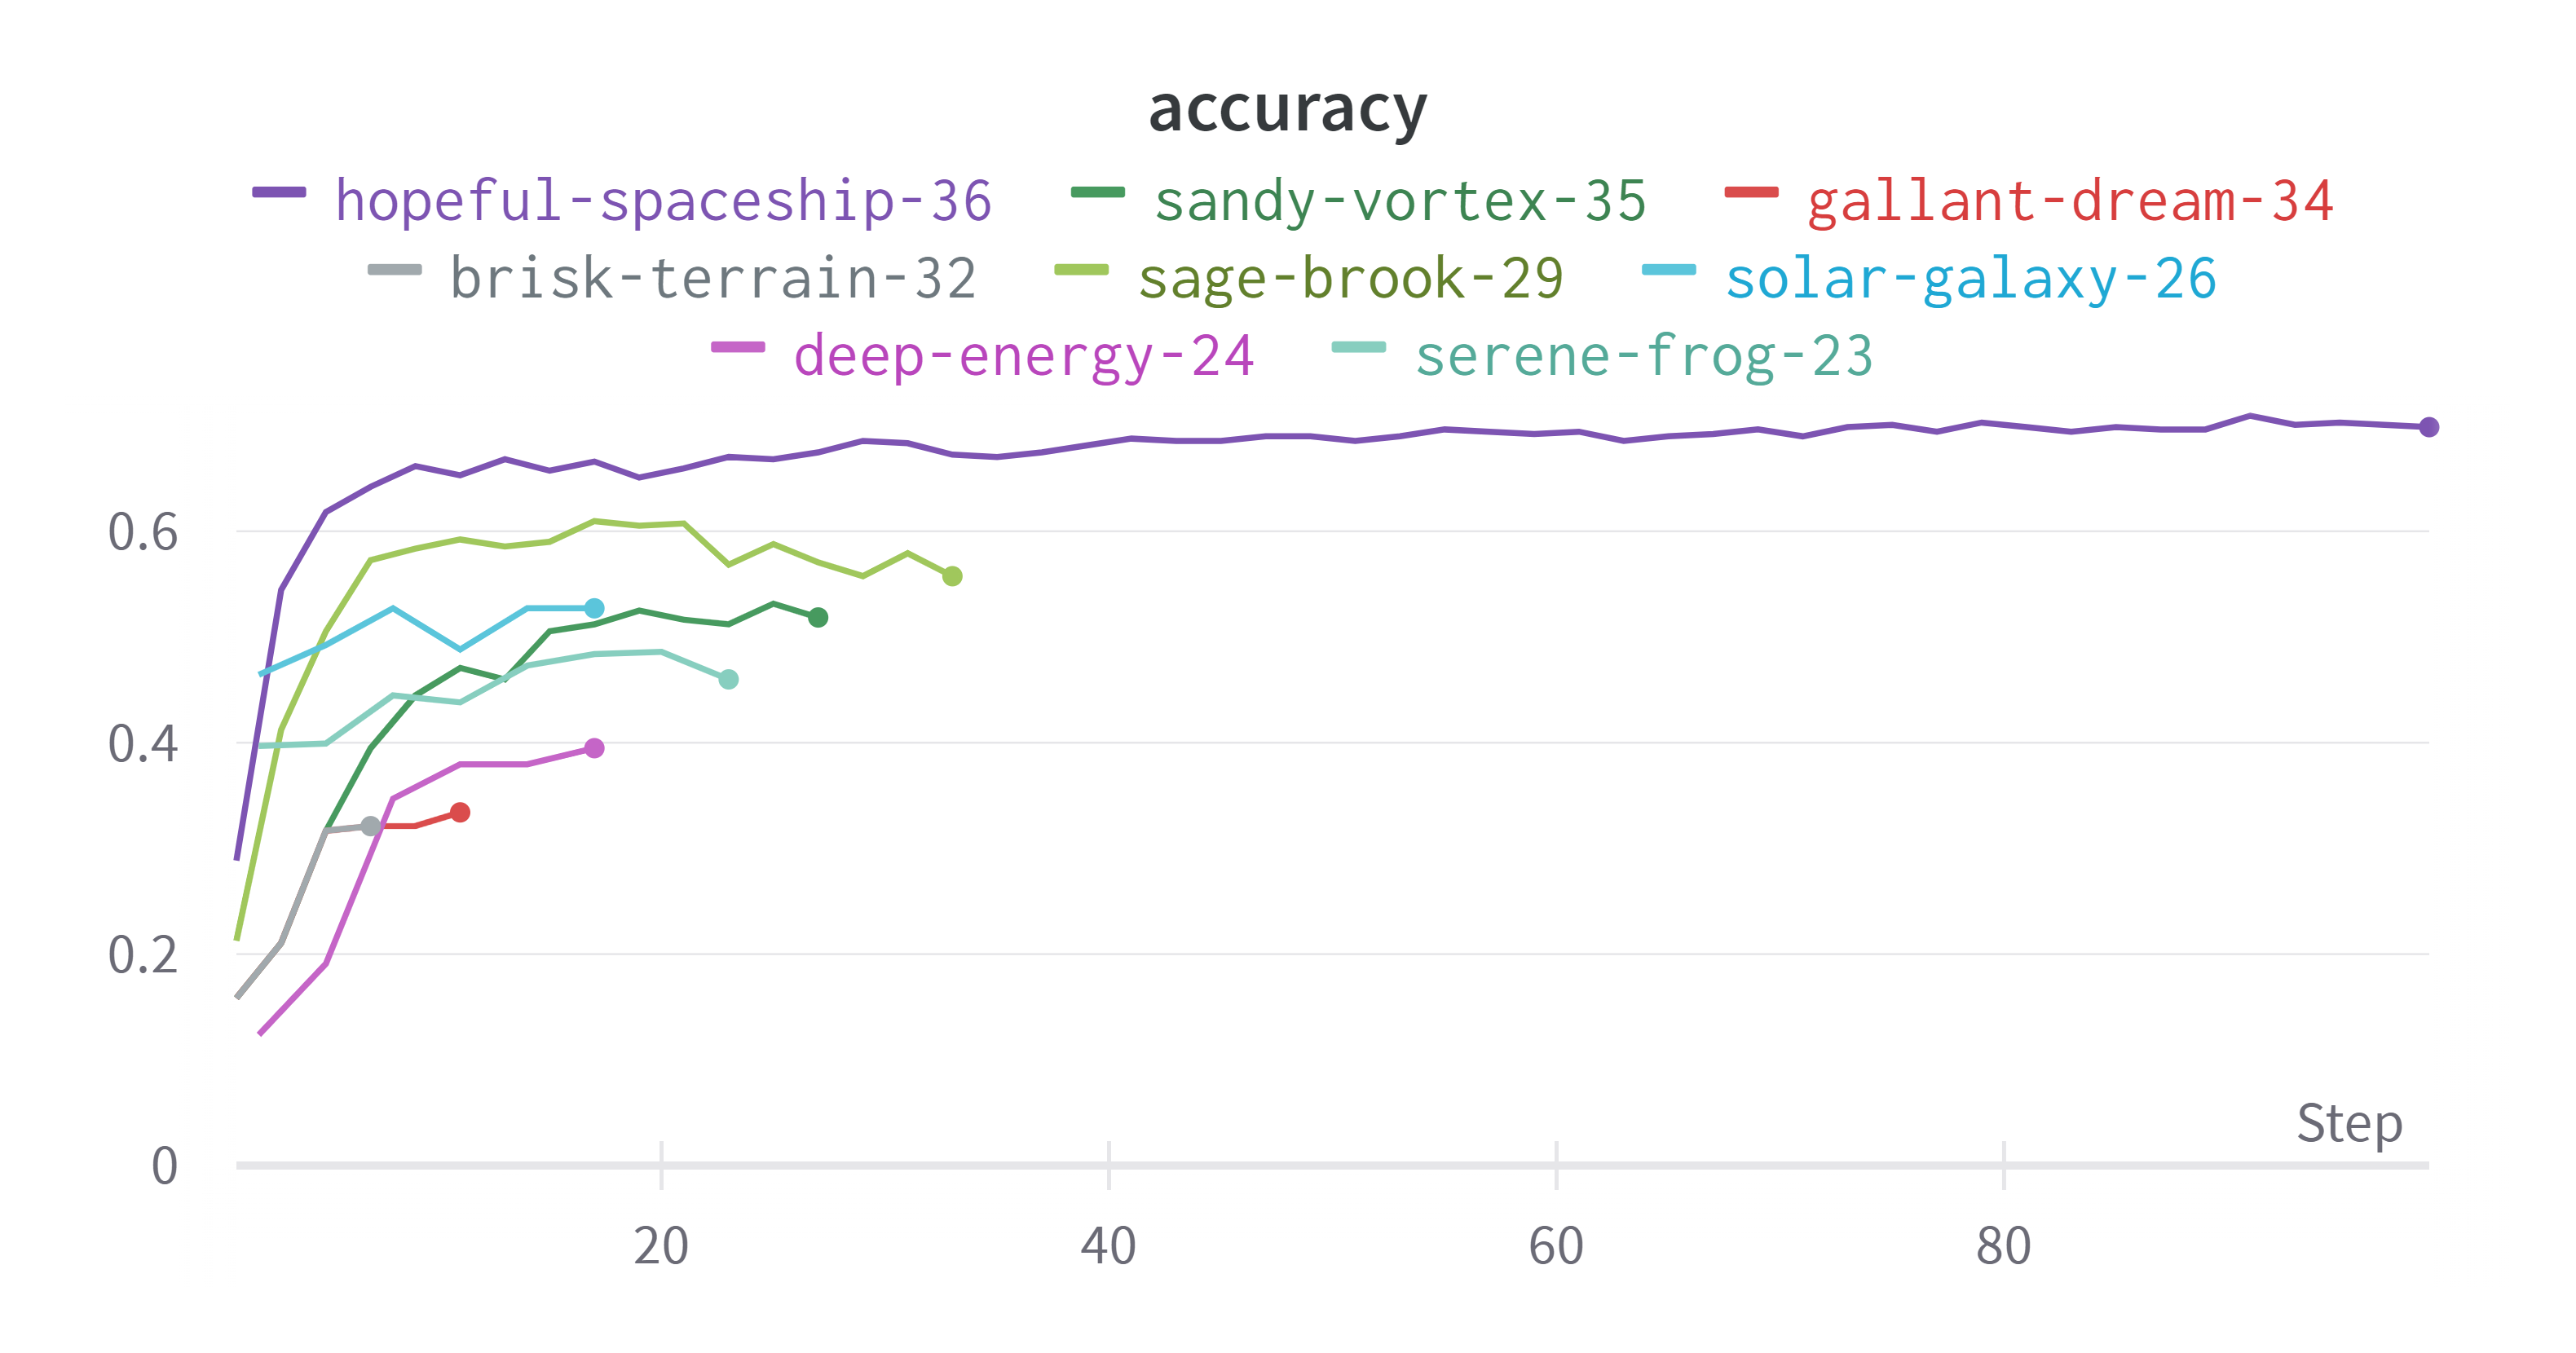

In [26]:
from IPython.display import Image
Image('img/accuracy.png')

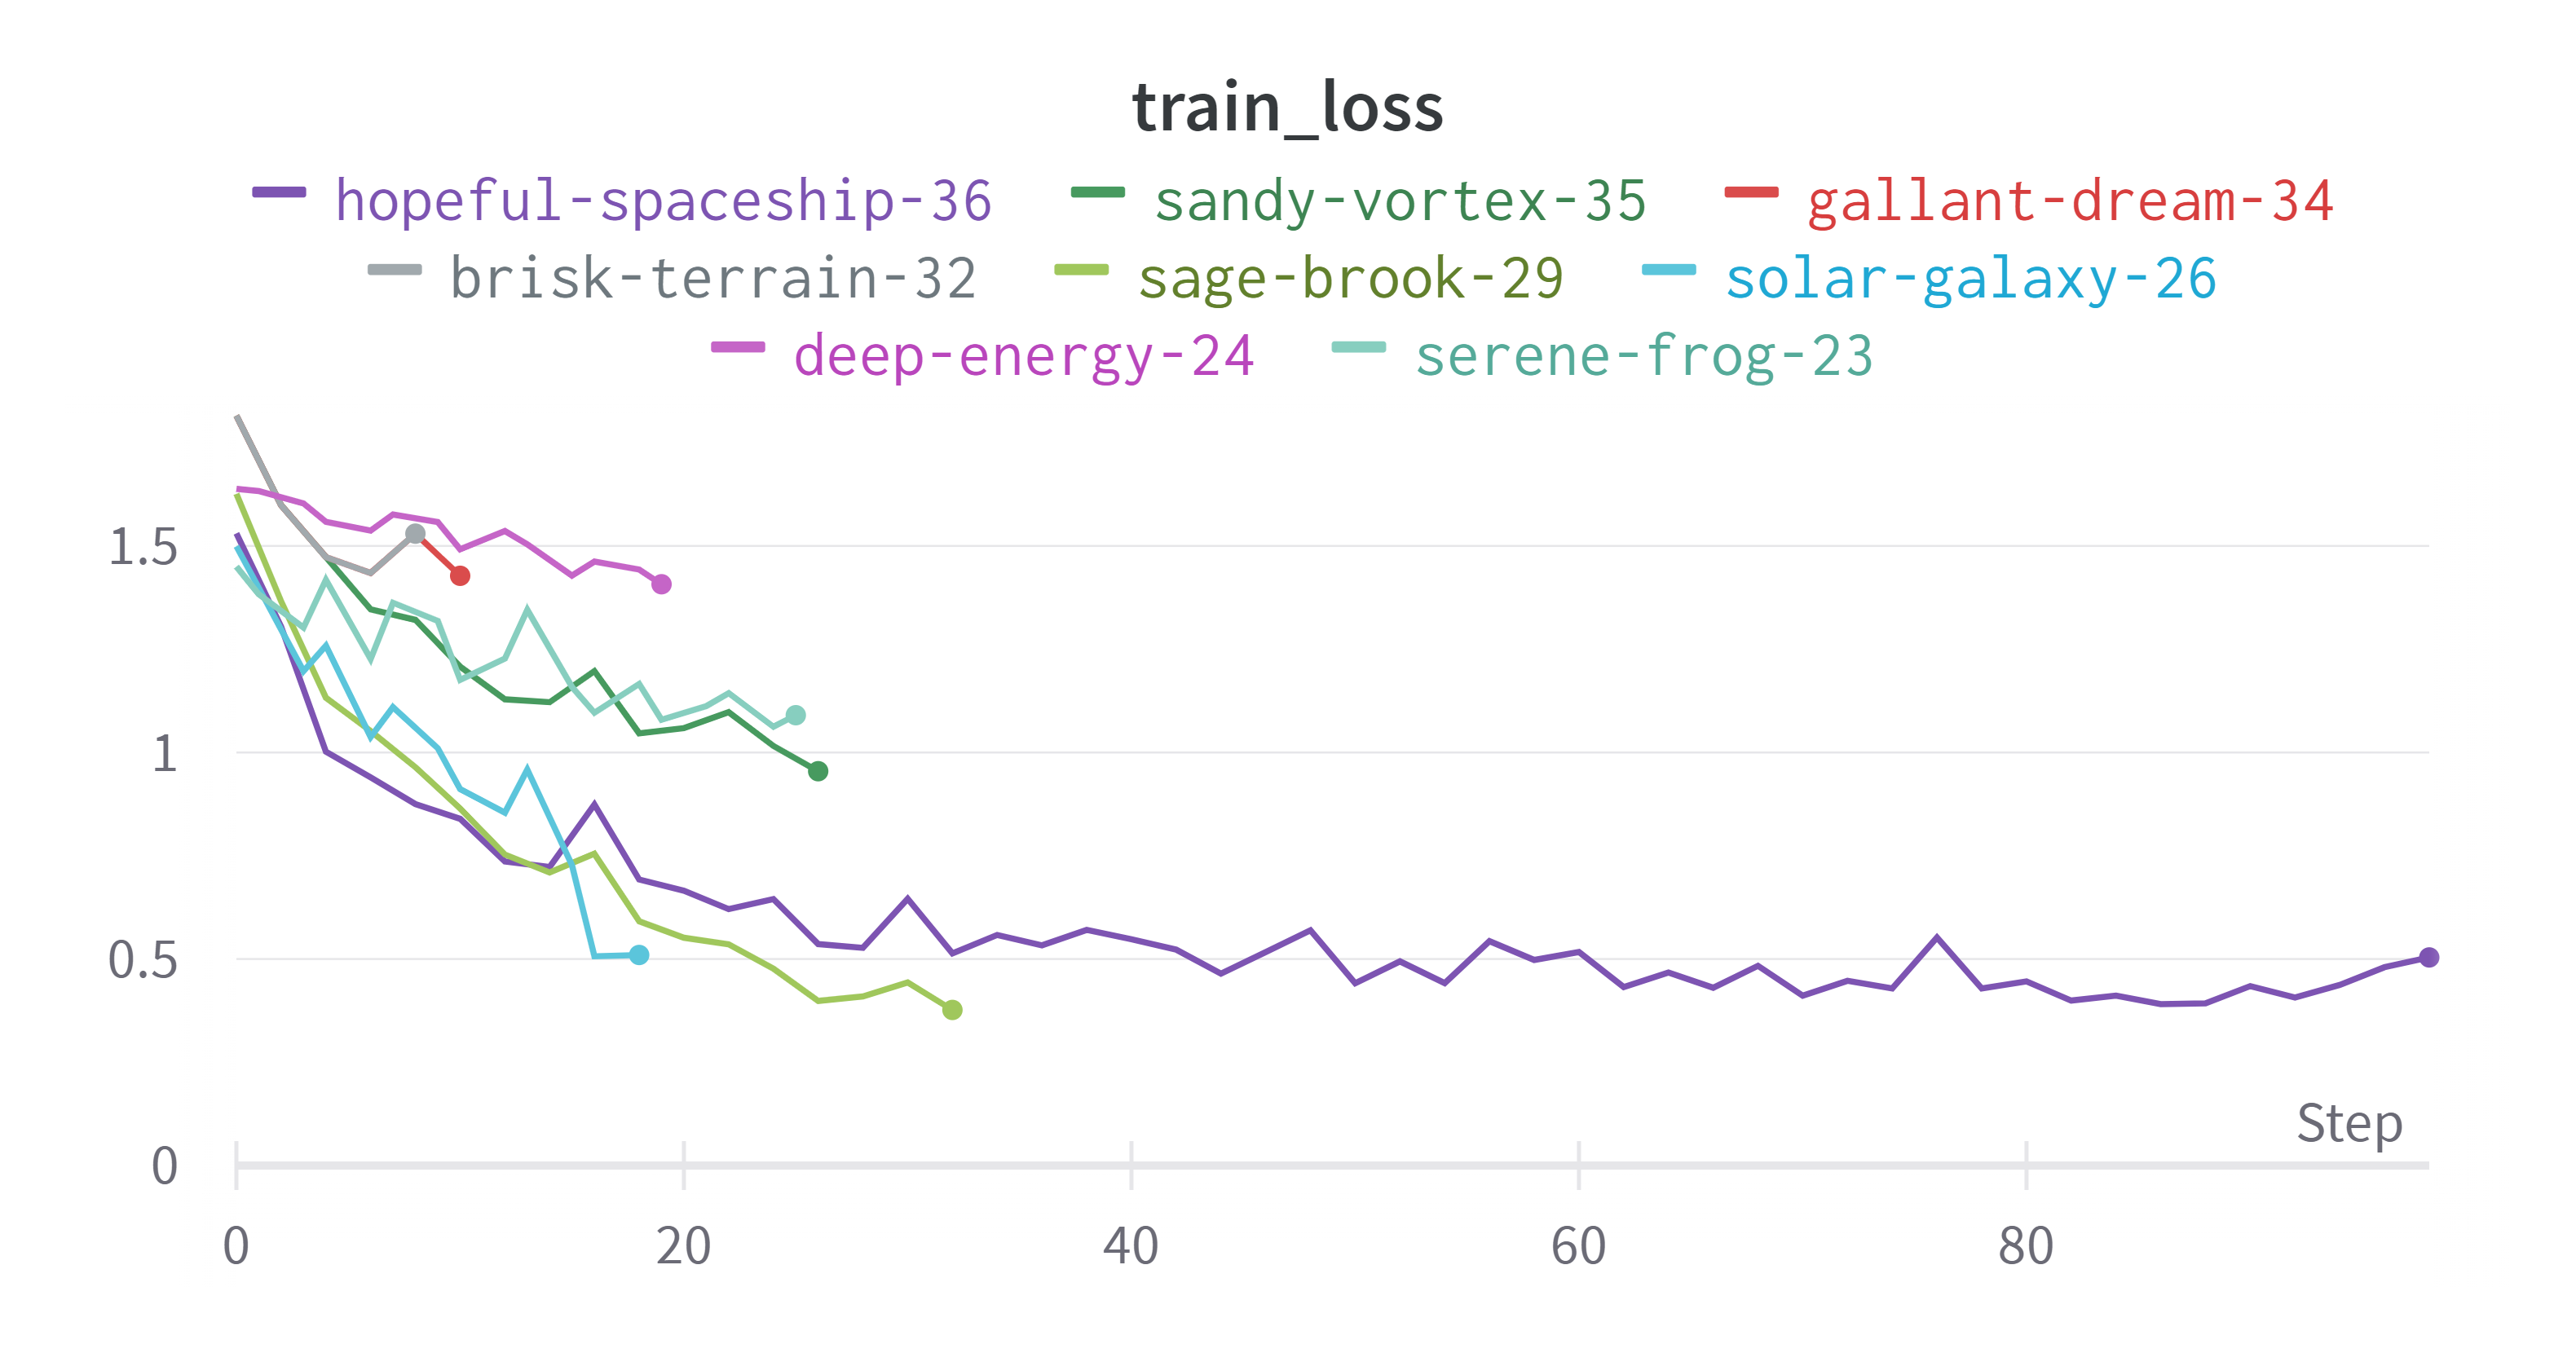

In [27]:
Image('img/train_loss.png')

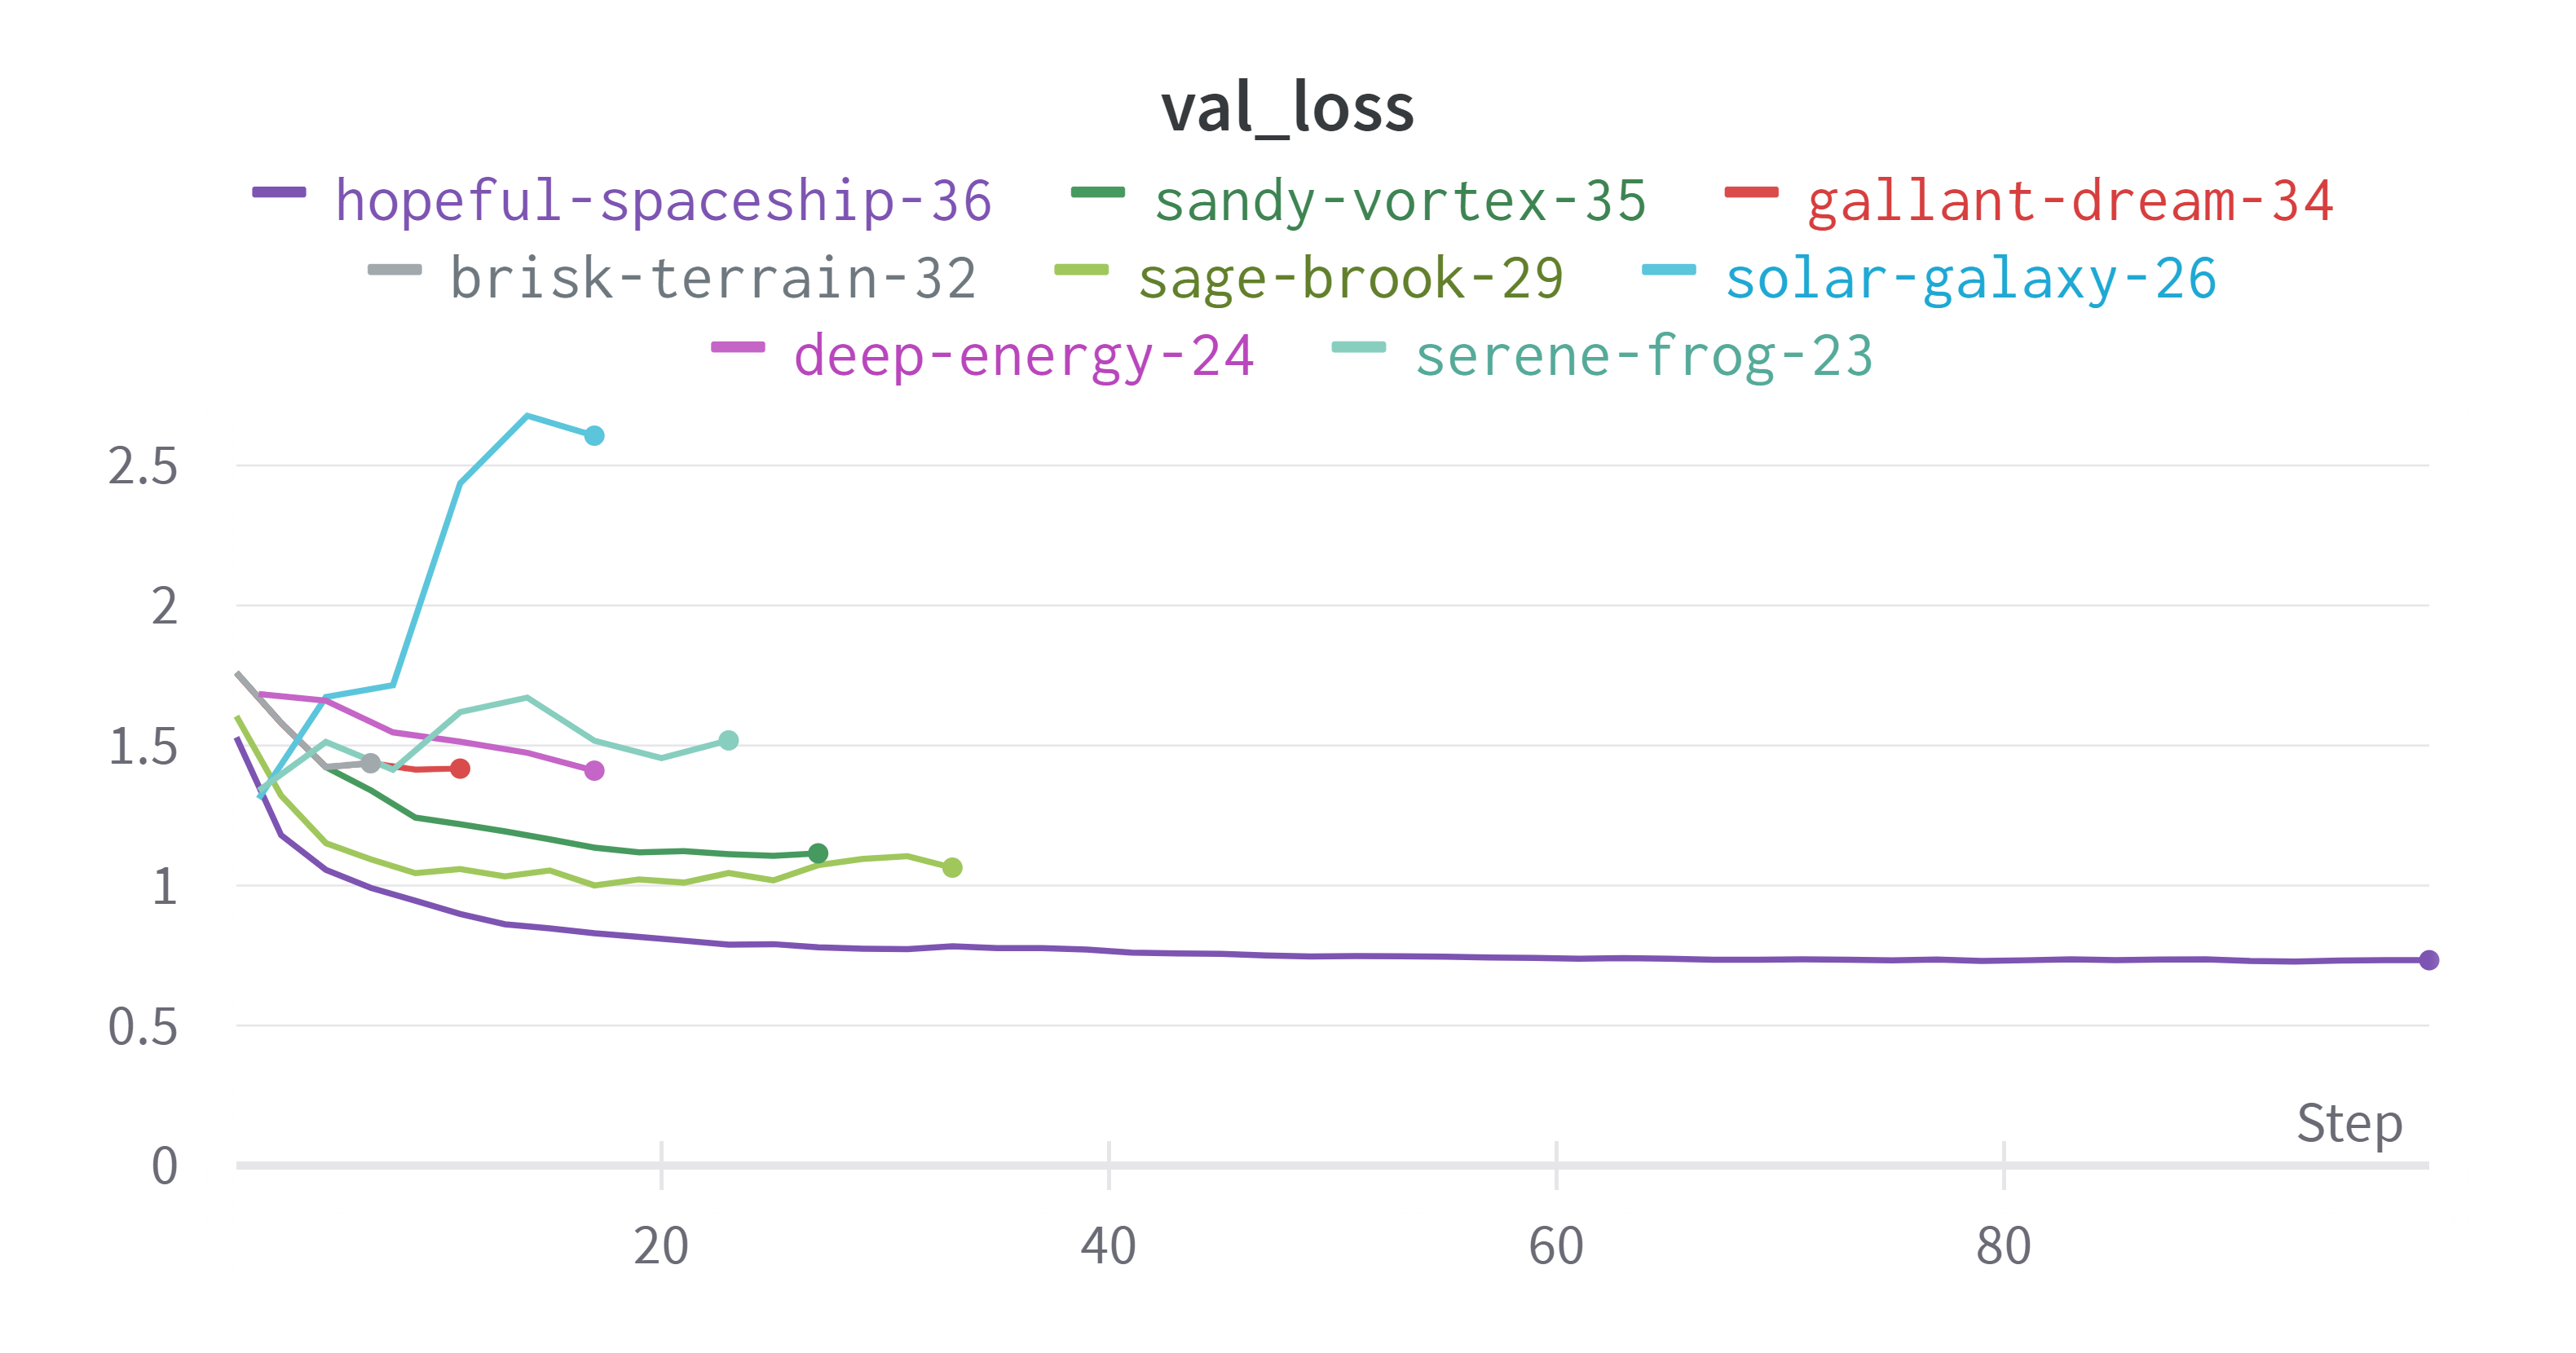

In [28]:
Image('img/val_loss.png')